In [1]:
q = """
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
"""             
from IPython.core.display import display, HTML
display(HTML(q))

# Regression Analysis

### What is Regression?
Regression is a statistic measure that used to determine the strength of the relationship between one dependent variable (y) and a series of other independent variables(X). It a parametric predictive modelling technique as it makes certain assumption based on dataset. 
Mathematically, a linear function is used to predict the dependent variable from independent variable in regression and it's given as follow

$$Y=\beta_0 + \beta_1 X + \epsilon $$
> Y=Dependent variable (variable we predict) <br>
        X = independent variable (variable we use to make a prediction) <br>
        $\beta_0$ = Intercept (prediction value you get when X = 0) <br>
        $\beta_1$ = Slope (change in Y when X changes by 1 unit) <br>
        $\epsilon$ = Error (the residual value, i.e. the difference between actual and predicted values)
 
      

#### Ordinary Least Square (OLS)
Regression uses a technique Ordinary Least Square (OLS) to reduce the error ($\epsilon$). 

## 1. Loading airfoil_self_noise dataset
This data has 5 independent variables and Sound_pressure_level as the dependent variable (to be predicted). In predictive modeling, we should always check missing values in data. If any data is missing, we can use methods like mean, median, and predictive modeling imputation to make up for missing data.

In [2]:
#imports 
import pandas as pd
import pyodbc
import numpy as np
import scipy.stats as stats
import seaborn as sb
import matplotlib.pyplot as plt
import random
%matplotlib inline
pd.options.display.max_columns = None

In [3]:
#Style settings
pd.set_option('display.max_columns', None)
sb.set_style("whitegrid")
colors = ['yellowgreen', 'lightskyblue','lightcoral', 'gold', 'orange']
random_seed = 134

In [4]:
data_file = 'airfoil_self_noise.csv'

data_df = pd.read_csv(data_file, header=0)
data_df.head()

,Frquency(Hz),Angle_of_Attack,Chord_Length,Free_stream_velocity,Displacement,Sound_pressure_level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


Check for missing data in database

In [5]:
data_df.apply(lambda x : sum(pd.isnull(x))/len(data_df)*100)

Frquency(Hz)            0.0
Angle_of_Attack         0.0
Chord_Length            0.0
Free_stream_velocity    0.0
Displacement            0.0
Sound_pressure_level    0.0
dtype: float64

This data set has no missing values. Good for us! Now, to avoid multicollinearity, let's check correlation matrix.

As we discussed above, regression is a parametric technique, so it makes assumptions. Let's look at the assumptions it makes:

1. There exists a **linear and additive relationship** between dependent (DV) and independent variables (IV). 
2. There must be **no correlation** among independent variables. Presence of correlation in independent variables lead to **Multicollinearity**. 
3. The error terms must possess constant variance. Absence of constant variance leads to **heteroskedestacity**.
4. The error terms must be uncorrelated i.e. error at ∈t must not indicate the at error at ∈t+1. Presence of correlation in error terms is known as **Autocorrelation**.
5. The dependent variable and the error terms must possess a **normal distribution**.

Presence of these assumptions make regression quite **restrictive**. By restrictive I meant, the performance of a regression model is conditioned on fulfillment of these assumptions.

### correlation matrix

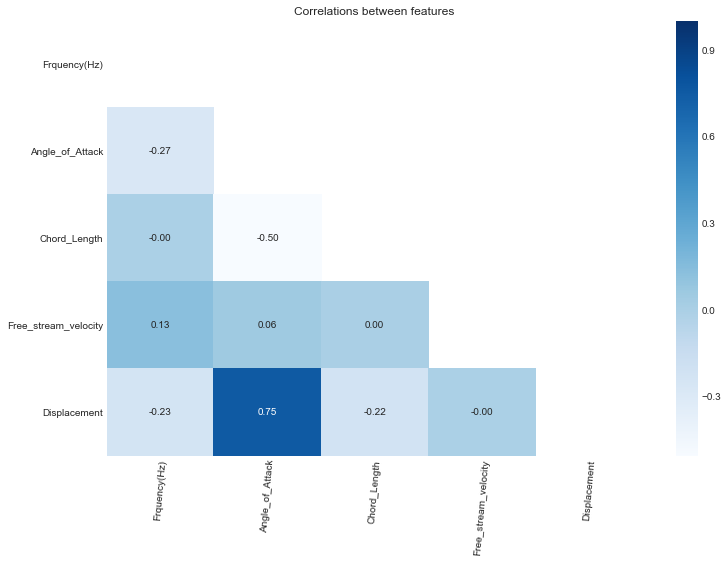

In [6]:
features_df = data_df.iloc[:, :-1]
target_df = data_df['Sound_pressure_level']

all_corr = features_df.corr(method = 'pearson')

mask = np.zeros_like(all_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = plt.figure(figsize=(12, 8))
ax = sb.heatmap(all_corr, cmap='Blues', annot=True, fmt='.2f', mask = mask)
ax = plt.xticks(rotation=85)
ax = plt.title("Correlations between features")

After analyzing correlation plot, we can infer that Angle_of_Attack and Displacement show 75% correlation. It's up to us if we should consider this correlation % as a damaging level. Usually, correlation above 80% (subjective) is considered higher. Therefore, we can forego this combination and won't remove any variable.

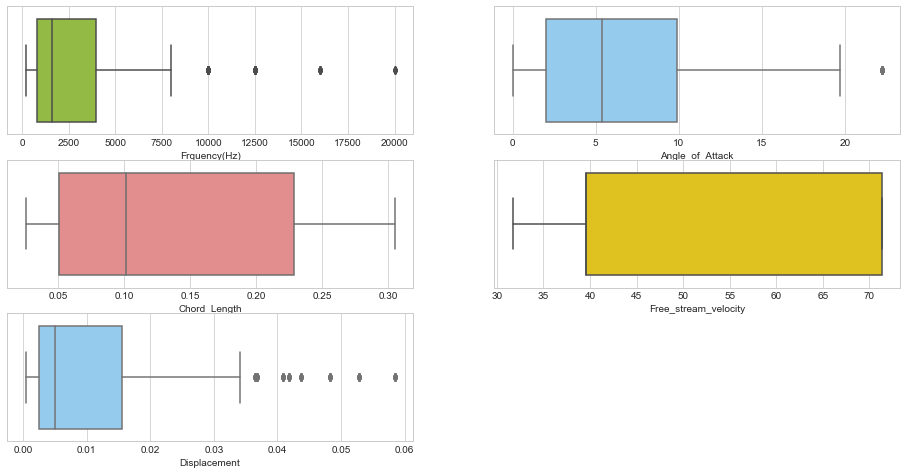

In [7]:
plt.figure(figsize = (16,8))
plt.subplot(3, 2, 1)
ax1 = sb.boxplot(data_df['Frquency(Hz)'], color = colors[0])
plt.subplot(3, 2, 2)
ax2 = sb.boxplot(data_df['Angle_of_Attack'], color = colors[1])
plt.subplot(3, 2, 3)
ax3 = sb.boxplot(data_df['Chord_Length'], color = colors[2])
plt.subplot(3, 2, 4)
ax4 = sb.boxplot(data_df['Free_stream_velocity'], color = colors[3])
plt.subplot(3, 2, 5)
ax5 = sb.boxplot(data_df['Displacement'], color = colors[1])

Here box plot is used to check Outlier values. Outliers have a substantial impact on regression's accuracy. Treating outliers is a tricky task. It requires in-depth understanding of data to acknowledge the existence of these high leverage points.

## 2. Training Linear Regression model
Split data into train and test

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

#Split data into train test
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.3, shuffle=True)

print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('X_test',y_test.shape)
reg = LinearRegression()

X_train (1052, 5)
X_test (451, 5)
y_train (1052,)
X_test (451,)


In [9]:
#Create Linear regression object
lm = LinearRegression()

#Train the model using training set
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
data_df['predicted'] = lm.predict(features_df)
data_df.to_csv('airfoil_self_noise_predicted.csv',index=False)

In [11]:
#Make predictions using the testing set
y_pred = lm.predict(X_test)

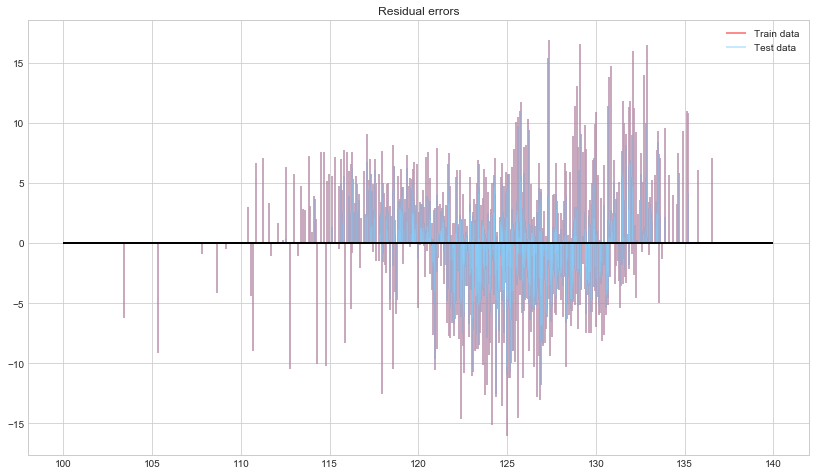

In [69]:
#my_color=np.where( lm.predict(X_train) - y_train>=0, 'orange', 'skyblue')

plt.figure(figsize = (14,8))

plt.vlines(x=lm.predict(X_train), ymin=0, ymax= lm.predict(X_train) - y_train, 
               alpha=.6, label = 'Train data', color='red')
#plt.scatter(lm.predict(X_train), lm.predict(X_train) - y_train, color='', alpha=1, s=10)

plt.vlines(x=lm.predict(X_train), ymin=0, ymax= lm.predict(X_train) - y_train, 
               color=colors[1], alpha=.6,label = 'Test data')

## plotting line for zero residual error
plt.hlines(y = 0, xmin = 100, xmax = 140, linewidth = 2)
 
## plotting legend
plt.legend(loc = 'upper right')
 
## plot title
plt.title("Residual errors")
 
## function to show plot
plt.show()

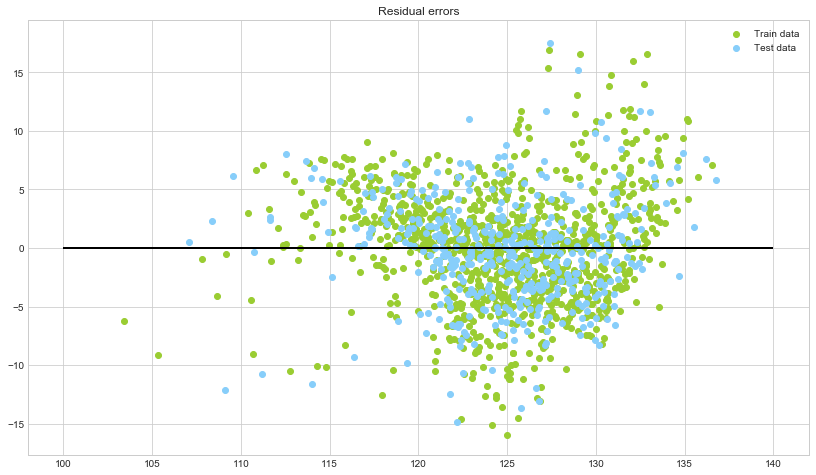

In [29]:
# plot for residual error 

plt.figure(figsize = (14,8))

## plotting residual errors in training data
plt.scatter(lm.predict(X_train), lm.predict(X_train) - y_train,
            color = colors[0],label = 'Train data')
 
## plotting residual errors in test data
plt.scatter(lm.predict(X_test), lm.predict(X_test) - y_test,
            color = colors[1] ,label = 'Test data')
 
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 100, xmax = 140, linewidth = 2)
 
## plotting legend
plt.legend(loc = 'upper right')
 
## plot title
plt.title("Residual errors")
 
## function to show plot
plt.show()

### Evaluation measures
**1. Variance score **
> As a measure of variability, the variance is used. If group of data are spread out, the variance will be a large number If $\hat{y}$ is the estimated target output, y the corresponding (correct) target output, and Var is Variance, the square of the standard deviation, then the explained variance is estimated as follow:<br>

>    $$explained\_variance(y,\hat{y}) = 1 - \frac{Var\{y-\hat{y}\}}{Var\{y\}}$$
> The best possible score is 1.0, lower values are worse.

In [13]:
from sklearn.metrics import explained_variance_score

# Explained variance score: 1 is perfect prediction
print('Variance score for our model: %.2f' % explained_variance_score(y_test, y_pred, multioutput='raw_values'))

Variance score for our model: 0.53


** 2. Mean Absolute error**
> The absolute error is the absolute value of the difference between the predicted value and the actual value. MAE tells us how big of an error we can expect from the predicted on average.
> If \hat{y}_i is the predicted value of the i-th sample, and y_i is the corresponding actual value, then the mean absolute error (MAE) estimated over n samples is defined as
> $$ MAE(y,\hat{y}) = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $$

In [14]:
from sklearn.metrics import mean_absolute_error

# The mean absolute error 
print('Mean absolute error for our model: %.2f' %mean_absolute_error(y_test, y_pred))

Mean absolute error for our model: 3.48


** 3. Mean squared error **
>The Mean Squared Error (MSE) is a measure of how close a fitted line is to data points. The smaller the Mean Squared Error, the closer the fit is to the data.
> $$ MSE(y,\hat{y}) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

** Note: ** Both MAE and MSE express average model prediction error in units of the variable of interest. Both metrics can range from 0 to $\infty$ and are indifferent to the direction of errors. They are negatively-oriented scores, which means lower values are better.

In [15]:
from sklearn.metrics import mean_squared_error

# The mean squared error
print("Mean squared error for our model: %.2f" % mean_squared_error(y_test, y_pred))

Mean squared error for our model: 20.71


** 4. $R^2$ score, the coefficient of determination **
> It provides a measure of how well future samples are likely to be predicted by the model. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a $R^2$ score of 0.0.

In [16]:
from sklearn.metrics import r2_score

# The R-squared
r_squared = r2_score(y_test, y_pred)
print("R-squared for our model: %.2f" % r_squared)

R-squared for our model: 0.53


**Note:** R-squared does not indicate whether a regression model is adequate. You can have a low R-squared value for a good model, or a high R-squared value for a model that does not fit the data! 

** 5. Adjusted $R^2$ **
> The problem with $R^2$ is that it keeps on increasing as you increase the number of variables, regardless of the fact that the new variable is actually adding new information to the model. To overcome that, we use adjusted $R^2$ which doesn't increase (stays same or decrease) unless the newly added variable is truly useful.

In [17]:
# The Adjusted R-squared
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("R-squared for our model: %.2f" % adjusted_r_squared)

R-squared for our model: 0.53


#### The fitted linear regression model, using statsmodels R style formula API:

In [18]:
import statsmodels.api as sm

model_fit = sm.OLS(y_train, X_train).fit()
print(model_fit.summary())

C:\Users\jaypate\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                             OLS Regression Results                             
Dep. Variable:     Sound_pressure_level   R-squared:                       0.939
Model:                              OLS   Adj. R-squared:                  0.938
Method:                   Least Squares   F-statistic:                     3204.
Date:                  Tue, 20 Mar 2018   Prob (F-statistic):               0.00
Time:                          09:53:18   Log-Likelihood:                -5103.1
No. Observations:                  1052   AIC:                         1.022e+04
Df Residuals:                      1047   BIC:                         1.024e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Frquency(Hz)

Let's understand the above regression output:

- **Intercept** - This is the $\beta_0$ value. It's the prediction made by model when all the independent variables are set to zero.
- **Coef** - This represents regression coefficients for respective variables. It's the value of slope.
- **std. err** - This determines the level of variability associated with the estimates. Smaller the standard error of an estimate is, more accurate will be the predictions.
- **t value** - t statistic is generally used to determine variable significance, i.e. if a variable is significantly adding information to the model. t value > 2 suggests the variable is significant.
- **p value** - It's the probability value of respective variables determining their significance in the model. p value < 0.05 is always desirable.

## 3. How do we know regression assumptions are violated in data
### Non graphic measures
1. **Durbin Watson Statistic (DW)** <br> This test is used to check autocorrelation. Its value lies between 0 and 4. A DW=2 value shows no autocorrelation. However, a value between 0 < DW < 2 implies positive autocorrelation, while 2 < DW < 4 implies negative autocorrelation.
2. **Variance Inflation Factor (VIF)** <br> This metric is used to check multicollinearity. VIF <=4 implies no multicollinearity but VIF >=10 suggests high multicollinearity. Alternatively, you can also look at the tolerance (1/VIF) value to determine correlation in IVs. In addition, you can also create a correlation matrix to determine collinear variables.
3. **Breusch-Pagan / Cook Weisberg Test** <br> This test is used to determine presence of heteroskedasticity. If you find p < 0.05, you reject the null hypothesis and infer that heteroskedasticity is present.

**Note:** You can view values of all test in the regression summary for our model)

### Graphic measures

In [19]:
#Calculations required for some of the plots:

# fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues

#print(model_fitted_y)

# model residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

#### 1.Residual vs. Fitted Values Plot
If you see any shape (curve, U shape), it suggests non-linearity in the data set. In addition, if you see a funnel shape pattern, it suggests your data is suffering from heteroskedasticity, i.e. the error terms have non-constant variance.

Text(0,0.5,'Residuals')

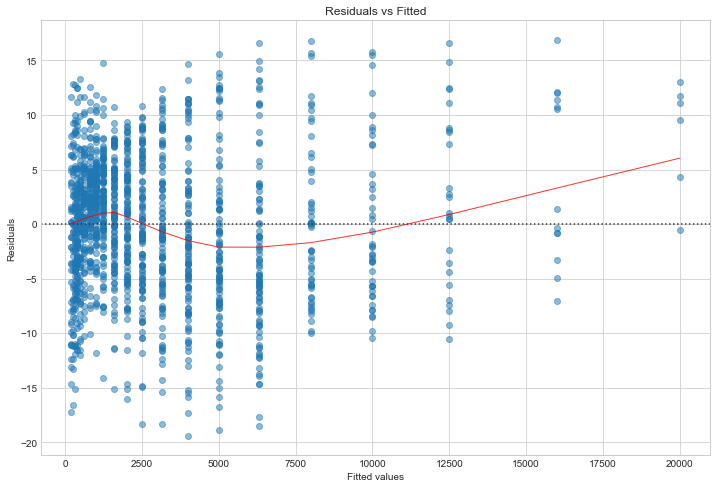

In [20]:
plt.figure(figsize = (12,8))
ax = sb.residplot(features_df['Frquency(Hz)'], target_df, 
                          lowess=True,
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
ax.set_title('Residuals vs Fitted')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')

#### 2. Normality Q-Q Plot
It is used to determine the normal distribution of errors. It uses standardized values of residuals. Ideally, this plot should show a straight line. If you find a curved, distorted line, then your residuals have a non-normal distribution (problematic situation).

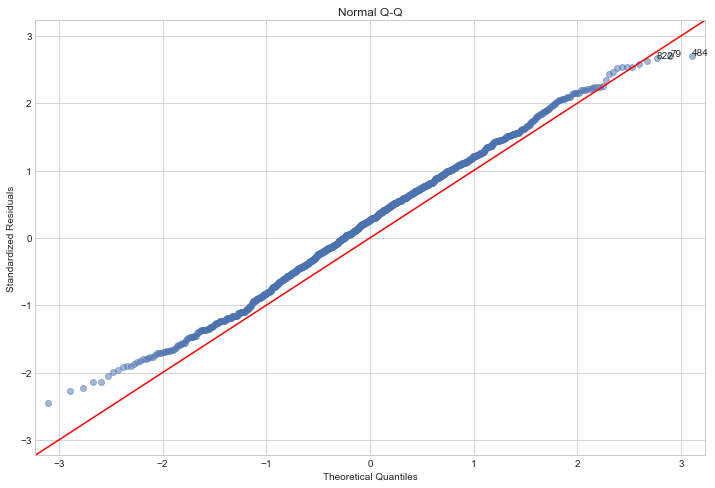

In [21]:
from statsmodels.graphics.gofplots import ProbPlot

QQ = ProbPlot(model_norm_residuals)
ax = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
ax.set_figheight(8)
ax.set_figwidth(12)

ax.axes[0].set_title('Normal Q-Q')
ax.axes[0].set_xlabel('Theoretical Quantiles')
ax.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    ax.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

#### 3. Scale Location Plot
This plot is also useful to determine heteroskedasticity. Ideally, this plot shouldn't show any pattern. Presence of a pattern determine heteroskedasticity.

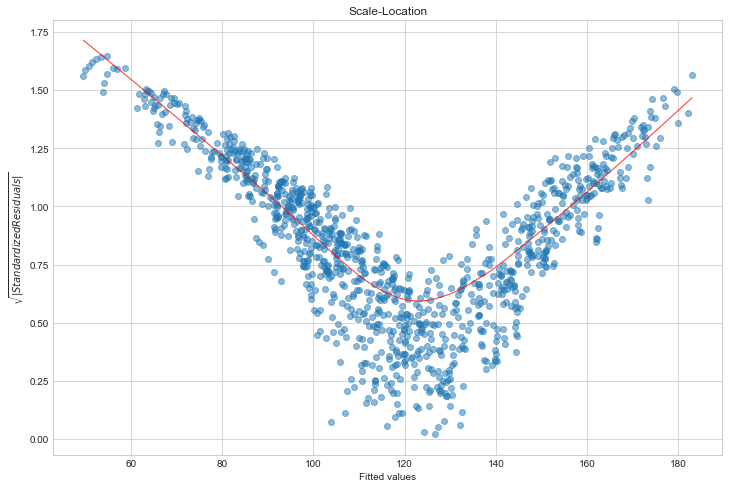

In [22]:
plot_lm = plt.figure(figsize = (12,8))
#plot_lm.set_figheight(8)
#plot_lm.set_figwidth(12)
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sb.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm.axes[0].set_title('Scale-Location')
plot_lm.axes[0].set_xlabel('Fitted values')
plot_lm.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

#### 4. Leverage plot
This plot shows if any outliers have influence over the regression fit. Anything outside the group and outside “Cook’s Distance” lines, may have an influential effect on model fit.

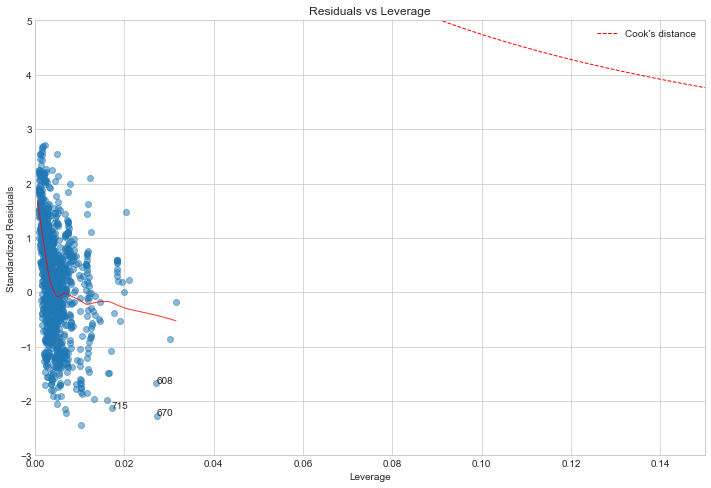

In [23]:
plot_lm = plt.figure(figsize = (12,8))
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sb.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm.axes[0].set_xlim(0, 0.150)
plot_lm.axes[0].set_ylim(-3, 5)
plot_lm.axes[0].set_title('Residuals vs Leverage')
plot_lm.axes[0].set_xlabel('Leverage')
plot_lm.axes[0].set_ylabel('Standardized Residuals')
# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
for i in leverage_top_3:
    plot_lm.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))
    
# shenanigans for cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')
p = len(model_fit.params) # number of model parameters
graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.150, 50), 
      'Cook\'s distance') # 0.5 line
graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.150, 50)) # 1 line
plt.legend(loc='upper right');

## 4. How can you improve the accuracy of a regression model ?
There is little you can do when your data violates regression assumptions. An obvious solution is to use tree-based algorithms which capture non-linearity quite well. But if you are adamant at using regression, following are some tips you can implement:<br>

1. If your data is suffering from non-linearity, transform the IVs using sqrt, log, square, etc.
2. If your data is suffering from heteroskedasticity, transform the DV using sqrt, log, square, etc. Also, you can use weighted least square method to tackle this problem.
3. If your data is suffering from multicollinearity, use a correlation matrix to check correlated variables. Let's say variables A and B are highly correlated. Now, instead of removing one of them, use this approach: Find the average correlation of A and B with the rest of the variables. Whichever variable has the higher average in comparison with other variables, remove it. Alternatively, you can use penalized regression methods such as lasso, ridge, elastic net, etc.
4. You can do variable selection based on p values. If a variable shows p value > 0.05, we can remove that variable from model since at p> 0.05, we'll always fail to reject null hypothesis.